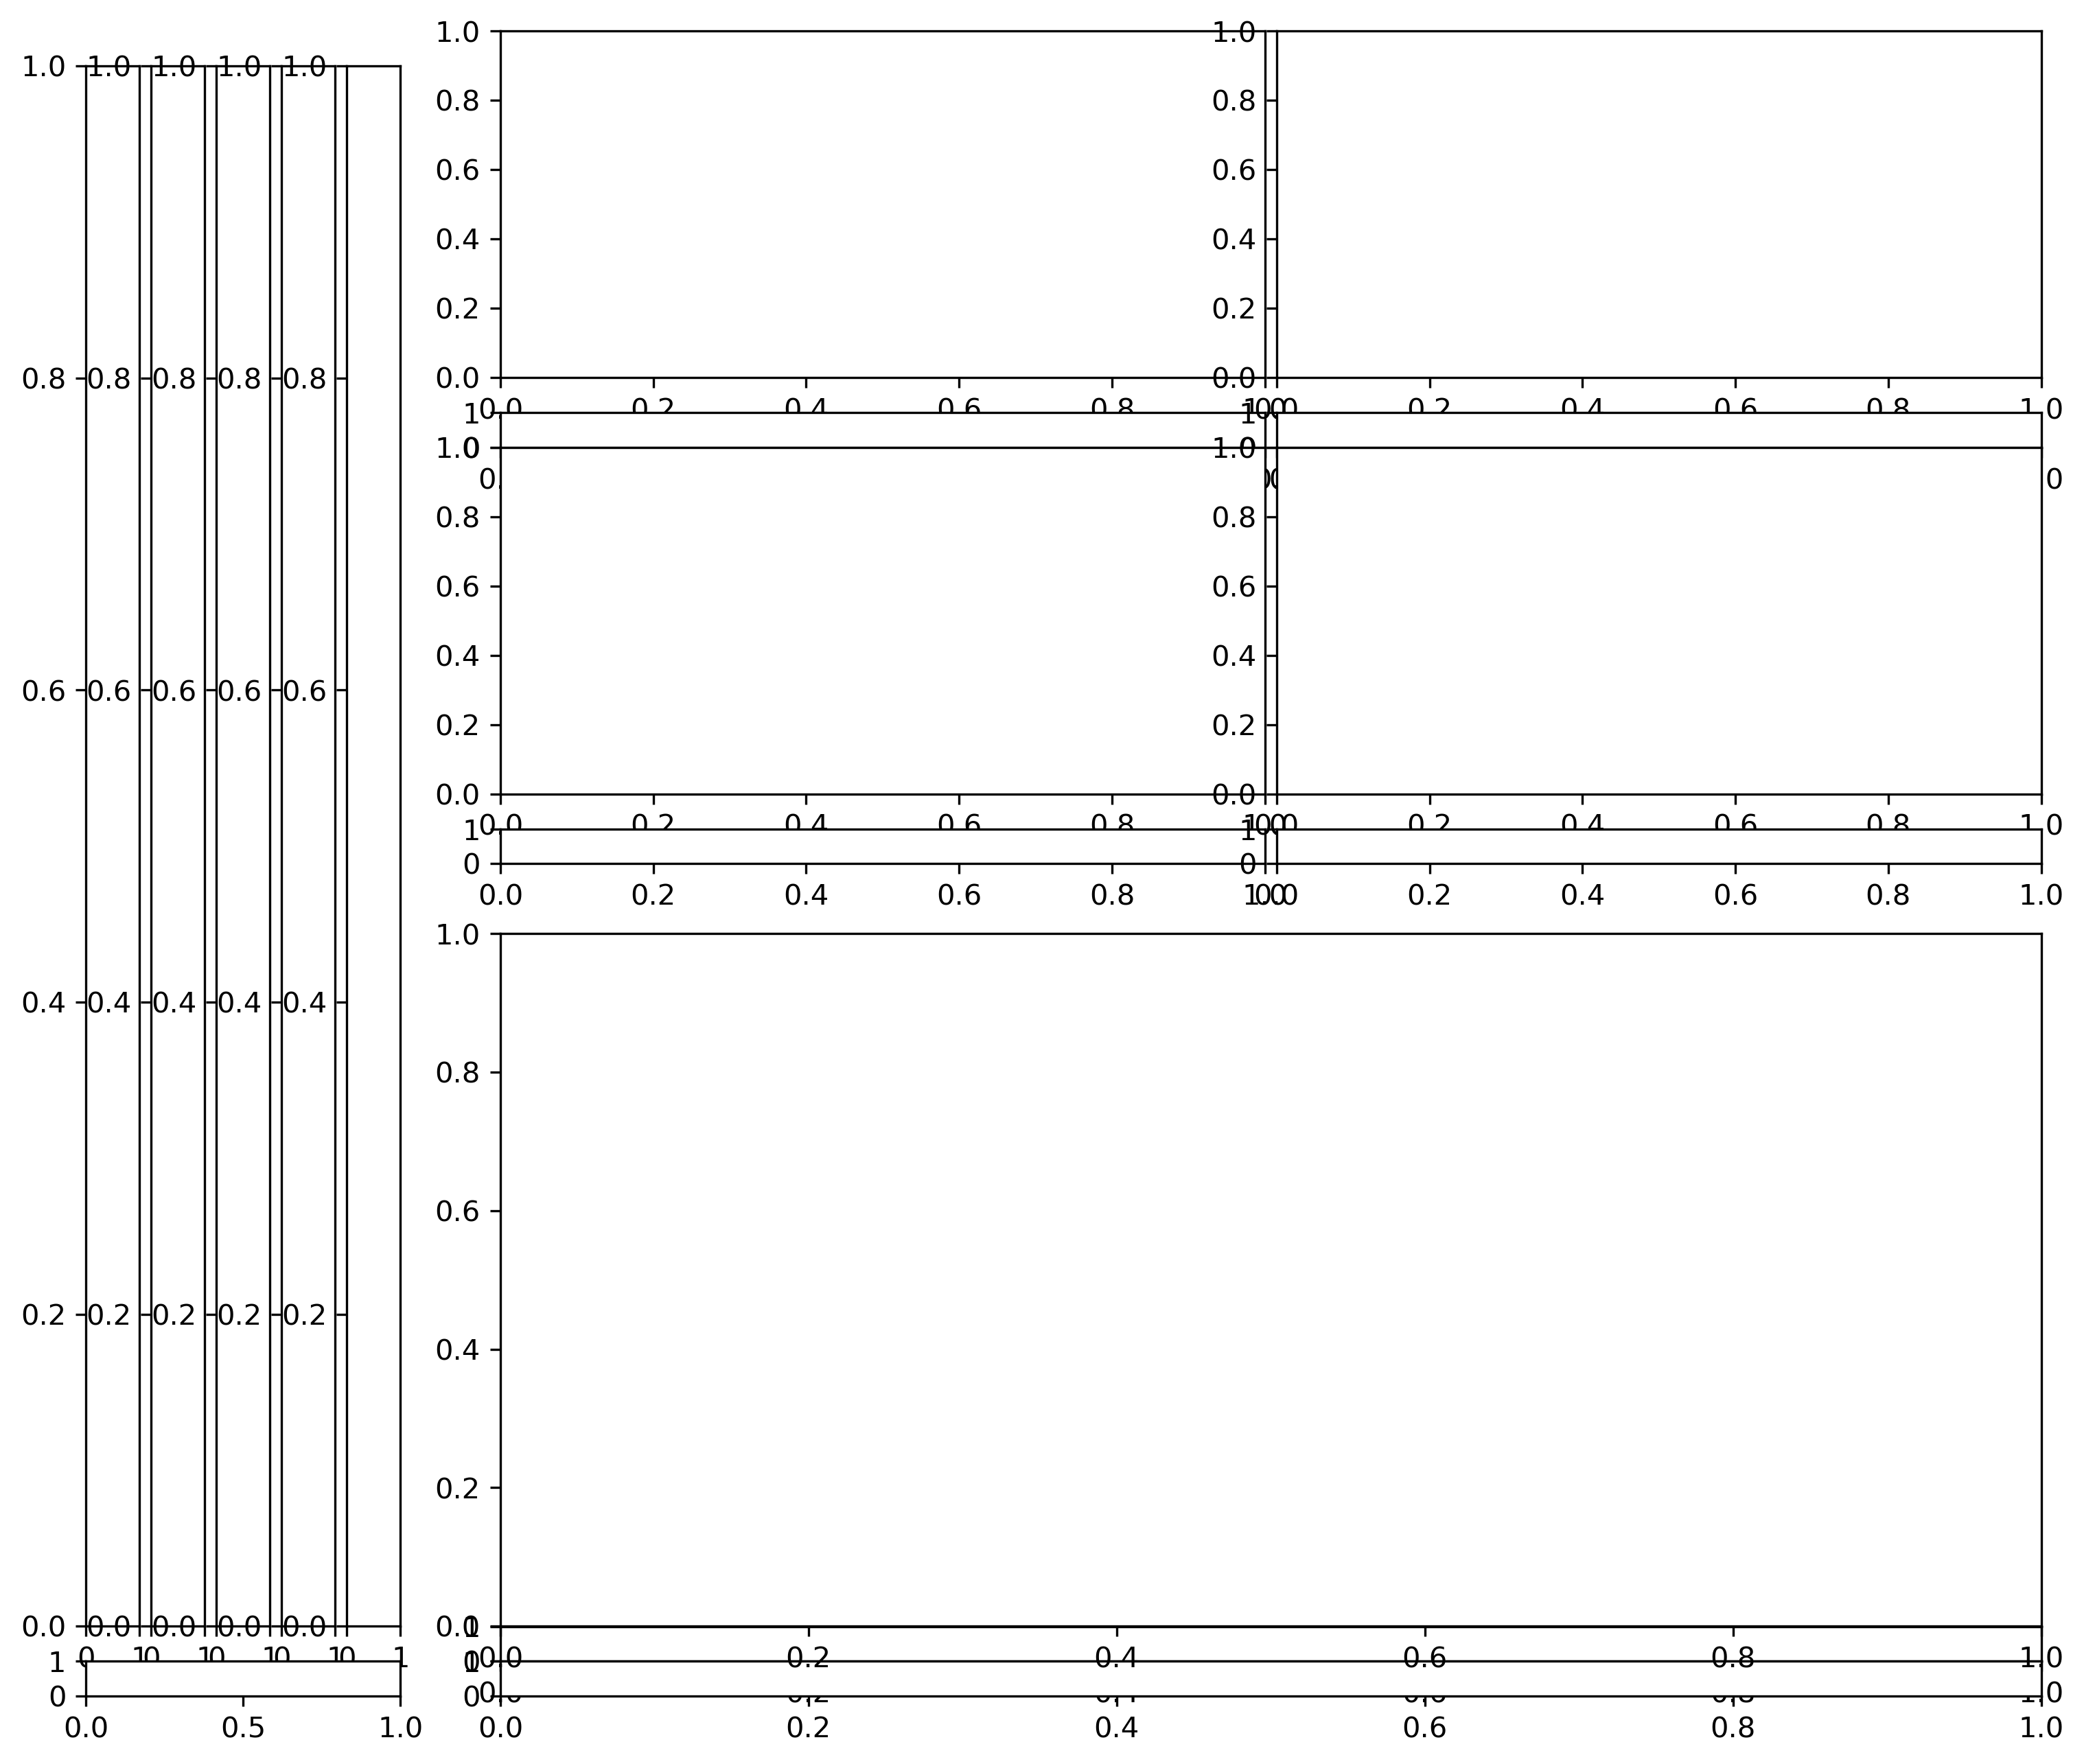

In [18]:
## import libraries
import os, sys
import yaml
import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
import glob
import itertools

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import textwrap
import matplotlib as mpl
%matplotlib inline

# Create figure
fig = plt.figure(figsize=(12.25, 10.5))
fig.dpi = 300
fmt = 'png'

nrows = 12
ncols = 8

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, 
              height_ratios=[0.05, 0.45, 0.05, 0.05, 0.5, 0.05, 0.05, 0.05, 0.05, 1, 0.05, 0.05],
              width_ratios = [0.07, 0.07, 0.07, 0.07, 0.07, 0.1, 1, 1], wspace=0.05, hspace=0.002)

## heatmap
varname_lst = ['IVT', 'Freezing Level', 'UV', 'Duration', 'QPF']
col_lst = [0, 1, 2, 3, 4]
for i, (col, varname) in enumerate(zip(col_lst, varname_lst)):
    ax = fig.add_subplot(gs[1:-2, col])

ann_ax = fig.add_subplot(gs[-1, :5])
    
## mclimate maps
row_lst = [0, 0, 4, 4]
row_lst2 = [2, 2, 5, 5]
col_lst = [6, 7, 6, 7]
var_lst = ['ivt', 'freezing_level', 'uv', 'qpf']
llat_lst = [True, False, True, False]
for i, (row, col) in enumerate(zip(row_lst, col_lst)):
    var = var_lst[i]
    ## percentile
    ax = fig.add_subplot(gs[row:row_lst2[i], col])

    cbax = plt.subplot(gs[row_lst2[i]+1,col]) # colorbar axis

## ar index plots
ax = fig.add_subplot(gs[-2, 6:])
cbax = plt.subplot(gs[-1, 6:]) # colorbar axis



ann_ax = fig.add_subplot(gs[-3, 6:])

plt.show()

In [ ]:
import os
import sys
import xarray as xr
import numpy as np
import richdem as rd

path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write

ext = [-179.5, -110., 10., 70.]

fname = '/expanse/nfs/cw3e/cwp140/downloads/GEFSv12_reforecast/hgt_sfc_2000100100_c00.grib2'
ds = xr.open_dataset(fname, engine='cfgrib')
ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
ds = ds.isel(step=1)
ds = ds.reindex(latitude=list(reversed(ds.latitude)))
ds = ds.sel(longitude=slice(ext[0], ext[1]), latitude=slice(ext[2], ext[3]))

## load the data into rich dem
rda = rd.rdarray(ds.orog.values, no_data=np.nan)
## calculate the slope
slope = rd.TerrainAttribute(rda, attrib='slope_riserun')
aspect = rd.TerrainAttribute(rda, attrib='aspect')

data = {
    "slope": (["lat", "lon"], slope),
    "aspect": (["lat", "lon"], aspect)
}

coords = {
    "lat": ds.latitude.values,
    "lon": ds.longitude.values
}

ds = xr.Dataset(data, coords=coords)
ds

In [ ]:
## pull in IVT direction from forecast
## load the reforecast
## testing 162 hr lead from Nov 21, 2013
## TODO write the code so that it chooses the right fname based on lead, day, month, year
fname = path_to_data + 'preprocessed/GEFSv12_reforecast/ivt/20131115_ivt_F147_F168.nc'
forecast = xr.open_dataset(fname)
forecast = forecast.rename({'longitude': 'lon', 'latitude': 'lat', 'ivt': 'IVT', 'ivtu': 'uIVT', 'ivtv':'vIVT'}) # need to rename this to match GEFSv12 Reforecast
forecast = forecast.reindex(lat=list(reversed(forecast.lat)))
forecast = forecast.sel(lon=slice(ext[0], ext[1]), lat=slice(ext[2], ext[3]))
forecast = forecast.isel(step=-1) ### need to fix this so it selects the right time step based on input
forecast = forecast.mean('number') # ensemble mean

## testing 162 hr lead to Nov 21, 2023
fname = path_to_data + '/downloads/GFS_025d/GFS_IVT_2023111406_F162.nc'
forecast2 = xr.open_dataset(fname)
forecast2 = forecast2.rename({'lon_0': 'lon', 'lat_0': 'lat'}) # need to rename this to match GEFSv12 Reforecast
forecast2 = forecast2.assign_coords({"lon": (((forecast2.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
forecast2 = forecast2.sel(lon=slice(ext[0], ext[1]), lat=slice(ext[2], ext[3]))
init_time = pd.to_datetime('2023111406', format='%Y%m%d%H')
valid_time = init_time + timedelta(hours=162)
forecast2 = forecast2.assign(valid_time=valid_time)
forecast2 = forecast2.assign(time=init_time)

forecast_lst = [forecast, forecast2]
fc_lst = []
for i, fc in enumerate(forecast_lst):
## calculate IVT direction 
    uvec = units.Quantity(fc['uIVT'].values, "m/s")
    vvec = units.Quantity(fc['vIVT'].values, "m/s")
    ivtdir = mpcalc.wind_direction(uvec, vvec)
    # forecast['ivtdir'] = ivtdir
    
    fc = fc.assign(ivtdir=(['lat','lon'],ivtdir.magnitude))
    fc = fc.assign({'orog': (['lat', 'lon'], ds.orog.values)})
    fc = fc.assign({'slope': (['lat', 'lon'], slope)})
    fc = fc.assign(aspect=(['lat','lon'],np.asarray(aspect)))
    fc = fc.assign(diff_dir=(['lat','lon'],((ivtdir.magnitude-aspect) % 360)))
    ## get the index value for direction
    da = fc.diff_dir
    mask = ((da >= 0) & (da <= 30)) | ((da >= 330) & (da <= 360)) | ((da >= 150) & (da <= 210))
    filled = xr.where(mask, 0.5, 0.0).rename("ivt_point")
    fc["ivt_point"] = filled
    fc_lst.append(fc)

fc_lst[1]

In [ ]:
varname_lst = ['orog', 'slope', 'aspect', 
            'IVT', 'diff_dir', 'ivt_point']
cmap_lst = [cmo.dense, cmo.dense, cmo.phase, 
            cmo.deep,  cmo.phase,  mcolors.ListedColormap(["white", "black"])]
bnds_lst = [np.arange(0, 3000, 250), np.arange(0, 550, 50), np.arange(0, 365, 30),
            np.arange(250, 2000, 250), np.arange(0, 365, 30), [0.0, 0.25, 0.75]]
cbarlbl_lst = ['Topography (m)', 'Slope (m)', 'Aspect (deg)', 
               'IVT (kg m-1 s-2)', 'IVT direction relative to topography (deg)', 'AR Index Value']

# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = forecast.lat.values
lons = forecast.lon.values
r = 2
dx = np.arange(lons.min().round(),lons.max().round()+r,r)
dy = np.arange(lats.min().round(),lats.max().round()+r,r)

# Create figure
fig = plt.figure(figsize=(12, 15))
fig.dpi = 300
fname = path_to_figs + 'ivt_direction_breakdown'
fmt = 'png'

nrows = 3
ncols = 5

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1], width_ratios = [1, 0.05, 0.1, 1, 0.05], wspace=0.001, hspace=0.05)
## use gs[rows index, columns index] to access grids

##################################
### Plot each item in the list ###
##################################
leftlats_lst = [True, False]*3
collst = [0, 3, 0, 3, 0, 3]
rowlst = [0, 0, 1, 1, 2, 2]
for i, varname in enumerate(varname_lst):
    ax = fig.add_subplot(gs[rowlst[i], collst[i]], projection=mapcrs) 
    if varname == 'IVT' or varname == 'ivt_point':
        ocean_mask = False
    else:
        ocean_mask = True
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=leftlats_lst[i], right_lats=False, bottom_lons=True,
                     mask_ocean=ocean_mask)
    bnds = bnds_lst[i]
    cmap = cmap_lst[i]
    ## plot filled contours
    norm = mcolors.BoundaryNorm(bnds, cmap.N)

    data = fc_lst[1][varname]
    # cf = ax.contourf(data.lon, data.lat, data.values, transform=datacrs,
    #                  levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')
    cf = ax.pcolormesh(data.lon, data.lat, data.values, transform=datacrs,
                       cmap=cmap, norm=norm, alpha=0.9)
    
    # ## plot terrain
    # cf = plot_terrain(ax, ext)
    
    # # Plot colored normalized vectors 
    # data =  get_every_other_vector(fc.diff_dir.values)
    # cmap = cmo.phase
    # bnds = np.arange(0, 365, 5)
    # norm = mcolors.BoundaryNorm(bnds, cmap.N)

    if varname == 'IVT':
        # plot vectors
        uvec =  get_every_other_vector((fc_lst[1].uIVT.values / fc_lst[1].IVT.values))
        vvec =  get_every_other_vector((fc_lst[1].vIVT.values / fc_lst[1].IVT.values))
    
        kw_quiver = {'headlength': 6, 'headaxislength': 4.5, 'headwidth': 4.5}
        Q = ax.quiver(lons, lats, uvec, vvec,
                      capstyle='round', units='width', scale_units='inches', scale=8., **kw_quiver)

    # # Contour Lines
    # clevs = np.arange(250., 2100., 250.)
    # cs = ax.contour(lons, lats, fc.IVT.values, transform=datacrs,
    #                  levels=clevs, colors='k',
    #                  linewidths=0.75, linestyles='solid')
    # plt.clabel(cs, **kw_clabels)
    
    # ## add plot labels
    # ts = pd.to_datetime(str(fc.time.values)) 
    # init_time = ts.strftime('%HZ %d %b %Y')
    
    # ts = pd.to_datetime(str(fc.valid_time.values)) 
    # valid_time = ts.strftime('%HZ %d %b %Y')
    
    # ax.set_title('Model Run: {0}'.format(init_time), loc='left', fontsize=8)
    # ax.set_title('Valid Date: {0}'.format(valid_time), loc='right', fontsize=8)

    # Add color bar
    cbax = plt.subplot(gs[rowlst[i], collst[i]+1]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
    cb.set_label(cbarlbl_lst[i], fontsize=11)
    cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()